In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Masking,Highway,Flatten,Reshape
from keras.layers.convolutional import Convolution1D

from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU, SReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import rcParams, pyplot as plt

rcParams['figure.figsize'] = [9, 6]
seed = 7

Using TensorFlow backend.


In [2]:
def shuffle_in_unison(a, b):
    np.random.seed(seed)
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

In [4]:
def _group_data():
    df = pd.read_csv('../AA_4_computed.csv', header=None).fillna(0)
    ds = df.values
    titles = ds[0, :]
    ds = ds[1:, :]
    fields = [2, 0, 4, 5, 6, 7, 8, 9, 10, 17]
    ds = ds[:, fields]  # manual selection of numeric fields
    # Y = np.reshape(ds[:, 2], (len(ds[:, 2]), 1))
    print(ds[-3:])
    encoder_r = LabelEncoder()
    encoder_p = LabelEncoder()
    encoder_y = LabelEncoder()
    encoder_r.fit(ds[:,0])
    encoder_p.fit(ds[:, 2])
    encoder_y.fit(ds[:, 1])
    ds[:, 0] = encoder_r.transform(ds[:,0])
    ds[:, 2] = encoder_p.transform(ds[:, 2])
    ds[:, 1] = encoder_y.transform(ds[:, 1])

    field_subset = pd.DataFrame(ds)
    g = field_subset.groupby([1]).groups.items()
    print(list(g))
    seasons = len(g)
    maxSeasonlen = 12
    feature_len = len(fields[1:])
    print(feature_len)
    np.zeros_like((seasons, maxSeasonlen))
    out = (np.zeros((seasons, maxSeasonlen, feature_len)),np.zeros((seasons, maxSeasonlen)))
    print(out[0][1])
    for index, (season_year, group_indexes) in enumerate(g):
        season = [field_subset.iloc[i].values for i in group_indexes]

        print(season)
        x = [m[1:] for m in season]
        y = [m[0] for m in season]
        print(x)
        out[0][index][:len(x)] = x
        out[1][index][:len(y)] = y
        # shuffles the season so that there is no bias against the later channels which are sparse more often
        out[0][index], out[1][index] = shuffle_in_unison(out[0][index],out[1][index])
    return out[0], out[1]

In [6]:
def create_grouped():
    feature_len = len(X[0, 0,:])
    season_len = len(X[0,:])
    model = Sequential()
    # model.add(Flatten(input_shape=(season_len,feature_len)))
    model.add(Convolution1D(1, 1,input_shape=(season_len,feature_len), input_length=feature_len))

    model.add(Flatten())

    model.add(Dense(int(feature_len *.75 * 50), init='normal',))
    model.add(Activation('relu'))
    model.add(Dropout(.05))
    # model.add(SReLU())
    model.add(Dense(int(feature_len / 2 * 50), init='normal', activation='relu'))
    model.add(Dense(int(feature_len / 4 * 50), init='normal', activation='tanh'))
    # model.add(Dense(1, init='normal', activation='sigmoid'))
    model.add(Dense(12, init='normal', activation='sigmoid'))
    model.add(Dense(12, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall', 'fmeasure'])
    return model

In [14]:
def make_plots(test, preds, acc, loss, trial):
    # lets see our predictions!
#     fig = plt.figure()
    # print(test)
    # print(preds)
    # return
    # plt.scatter(range(len(test)), test, c="g")
    # plt.scatter(range(len(preds)), preds, c="r")
    # plt.xlim(-2, len(preds) + 2)
    # plt.ylim(-0.05, 1.05)
    # plt.title('Predictions and actual values for trial %s' % (trial))
    # plt.legend(['actual', 'prediction'], loc='center')
    # # plt.show()
    # plt.savefig('tests/graphs/pred_%s.png' % trial)
    # plt.close(fig)
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(acc)
    #     plt.plot(hist.history['val_acc']) #only generate these metrics when using val keyword in fit()
    plt.title('model accuracy trial: %s' % (trial))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #     plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
#     plt.savefig('tests/graphs/acc_%s.png' % trial)
    plt.show()
    # summarize history for loss
    fig = plt.figure()
    plt.plot(loss)
    #     plt.plot(hist.history['val_loss'])
    plt.title('model loss trial: %s' % (trial))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [8]:
def train_group(train, vaild, trial):
    X_train = np.array([x for x in train[0]])
    X_valid = np.array([x for x in vaild[0]])
    hist = model.fit(X_train, train[1], nb_epoch=1000, batch_size=10, verbose=0)
    preds = model.predict_classes(X_valid, batch_size=10, verbose=0)
    # preds = model.predict(X_test, batch_size=50, verbose=0)
    scores = model.evaluate(X_valid, vaild[1], verbose=0)
    accs.append(scores[1] * 100)
    precs.append(scores[2] * 100)
    recs.append(scores[3] * 100)
    fscores.append(scores[4] * 100)
    print("_-_-_-_-_-_-_-_-_-_-_-_-_-_")
    print(scores, model.metrics_names)
    #     print(hist.history.keys())
    #     print(preds)
    make_plots(vaild[1], preds, hist.history['acc'], hist.history['loss'], trial)

In [9]:
def test_group(test):
    preds = model.predict_classes(test[0], batch_size=10, verbose=0)
    # preds = model.predict(X_test, batch_size=50, verbose=0)
    scores = model.evaluate(test[0], test[1], verbose=0)
    accs.append(scores[1] * 100)
    precs.append(scores[2] * 100)
    recs.append(scores[3] * 100)
    fscores.append(scores[4] * 100)
    print("_-_-_-_-TEST-_-_-_-_-_")
    print(scores, model.metrics_names)
    print(preds)
    print(test[1])

In [11]:
np.random.seed(seed)
X,Y = _group_data()
X_scaler = StandardScaler()
X = np.array([X_scaler.fit_transform(x) for x in X])
X,Y = shuffle_in_unison(X,Y)
X = X.astype(float)
x_train, x_test = [X[10:],X[:10]]
y_train, y_test = [Y[10:],Y[:10]]
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
trial = 1
accs = []
precs = []
recs = []
fscores = []
model = create_grouped()
print(model.layers[0].output_shape)
print(model.layers[1].output_shape)
print(model.layers[2].output_shape)
folds = list(kfold.split(x_train, y_train))

[['True' '1927' 'Paramount Famous Lasky' '7.8' '8086' '95' '7.4' '78' '7.6'
  '0']
 ['False' '1927' 'Fox' '7.8' '2090' '100' '9.3' '84' '8' 0]
 ['False' '1927' 'The Caddo Company' '6.9' '646' '100' '6.9' '75' '7.2' 0]]
[(0, [525, 526, 527]), (1, [520, 521, 522, 523, 524]), (2, [515, 516, 517, 518, 519]), (3, [510, 511, 512, 513, 514]), (4, [502, 503, 504, 505, 506, 507, 508, 509]), (5, [492, 493, 494, 495, 496, 497, 498, 499, 500, 501]), (6, [480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491]), (7, [468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479]), (8, [458, 459, 460, 461, 462, 463, 464, 465, 466, 467]), (9, [448, 449, 450, 451, 452, 453, 454, 455, 456, 457]), (10, [438, 439, 440, 441, 442, 443, 444, 445, 446, 447]), (11, [428, 429, 430, 431, 432, 433, 434, 435, 436, 437]), (12, [418, 419, 420, 421, 422, 423, 424, 425, 426, 427]), (13, [408, 409, 410, 411, 412, 413, 414, 415, 416, 417]), (14, [398, 399, 400, 401, 402, 403, 404, 405, 406, 407]), (15, [388, 389, 390,

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[5.7989287376403809, 0.25, 0.28571429848670959, 0.25, 0.26666662096977234] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


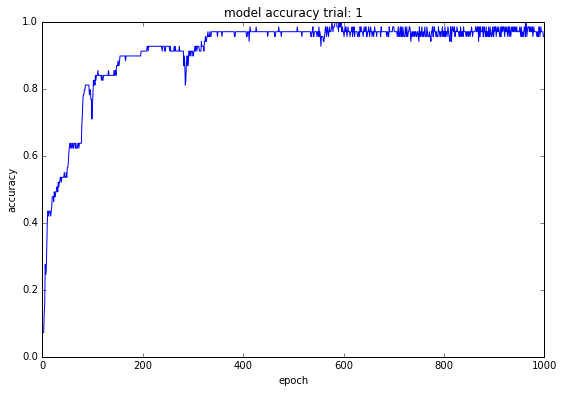

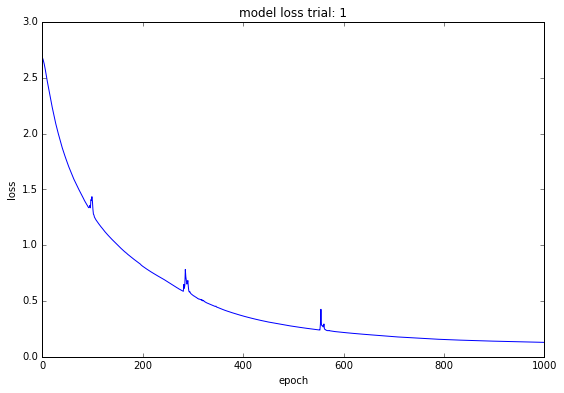

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[0.17200662195682526, 1.0, 1.0, 0.875, 0.93333327770233154] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


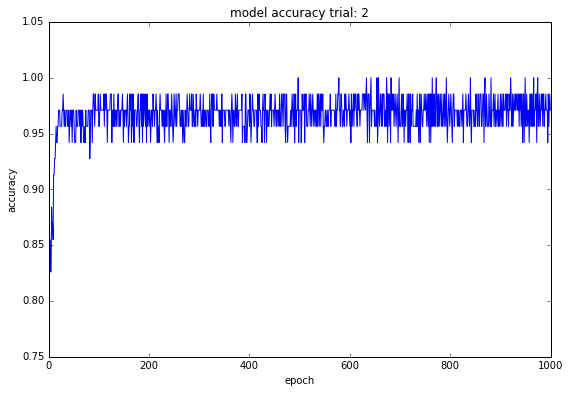

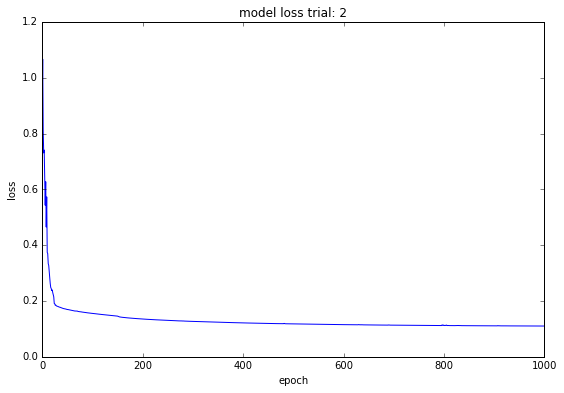

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[2.9513945579528809, 0.625, 0.75, 0.60000002384185791, 0.66666662693023682] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


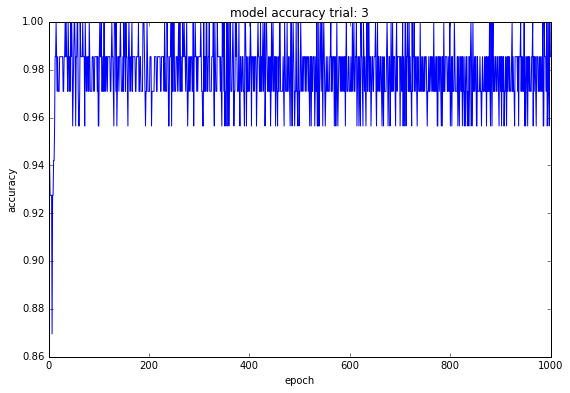

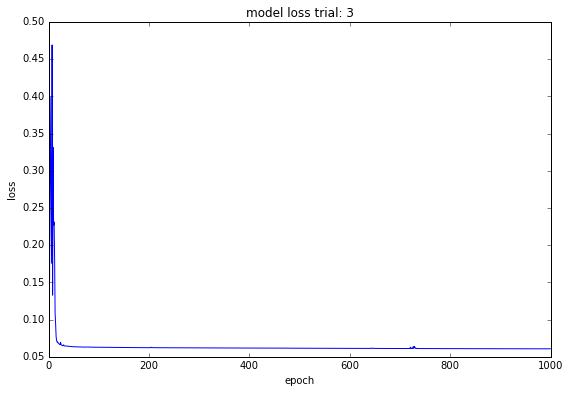

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[0.51925414800643921, 0.875, 0.875, 0.875, 0.87499994039535522] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


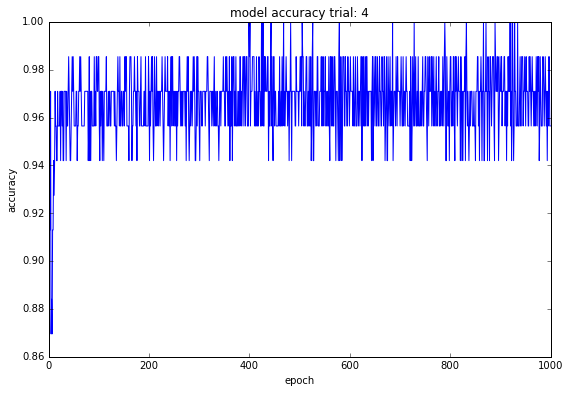

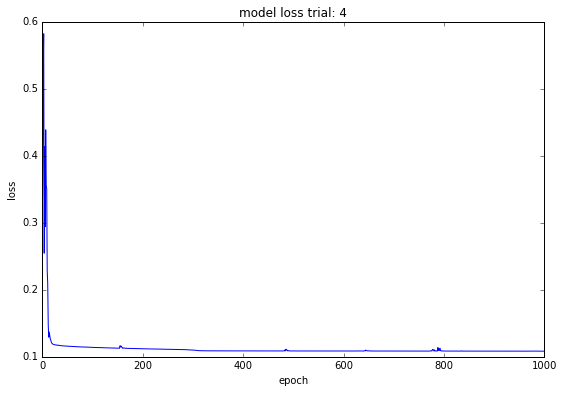

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[0.049873538315296173, 1.0, 1.0, 1.0, 1.0] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


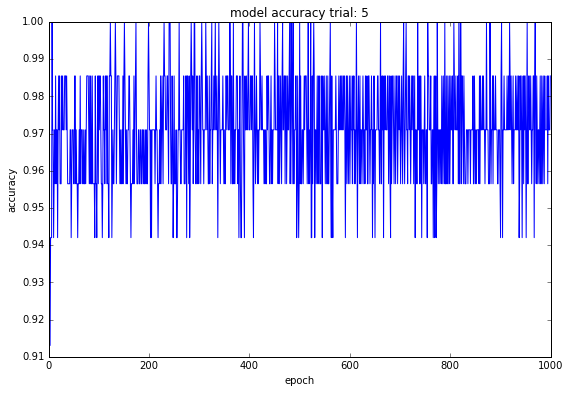

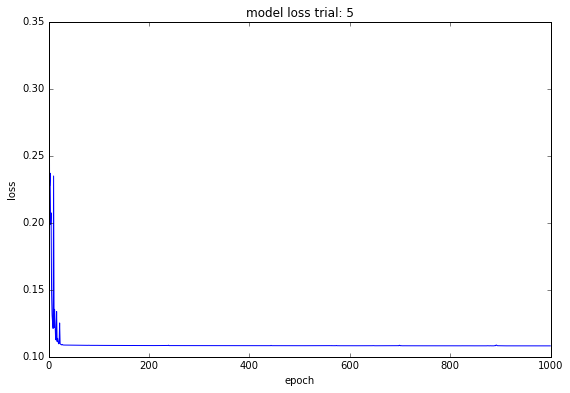

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[1.0748370885848999, 0.875, 0.875, 0.875, 0.87499994039535522] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


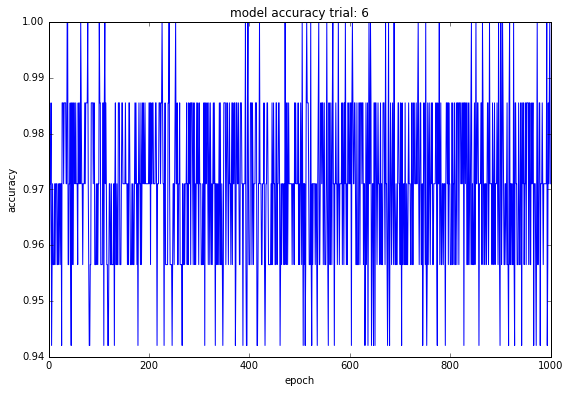

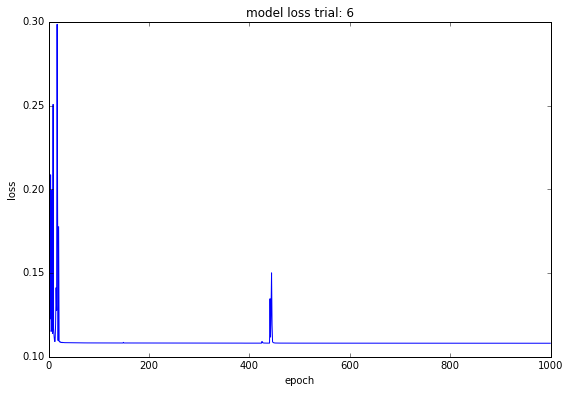

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[1.8778456449508667, 0.75, 0.875, 0.69999998807907104, 0.77777773141860962] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


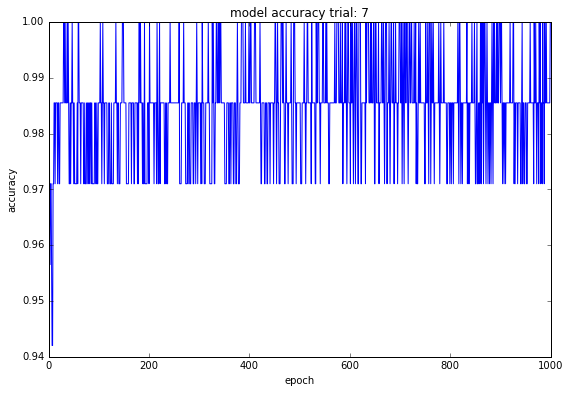

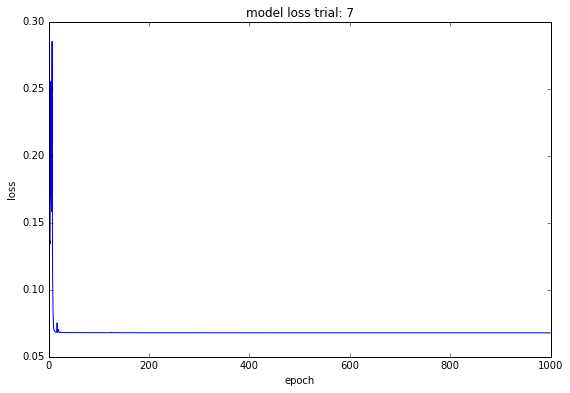

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[3.9118411540985107, 0.4285714328289032, 0.57142859697341919, 0.5, 0.53333330154418945] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


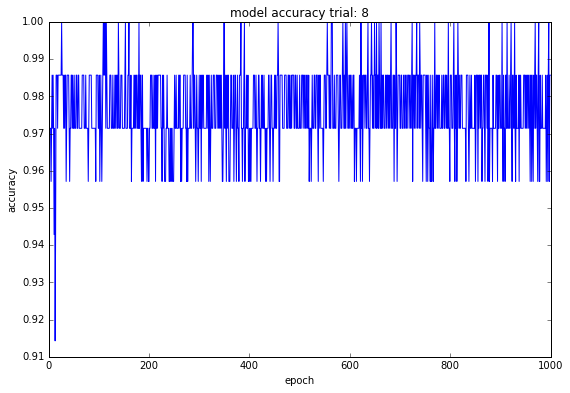

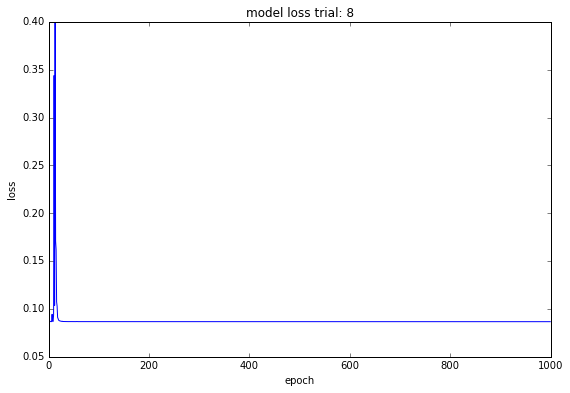

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[0.74994575977325439, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.85714280605316162] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


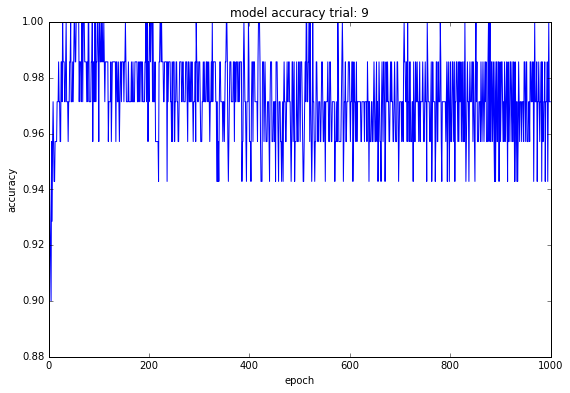

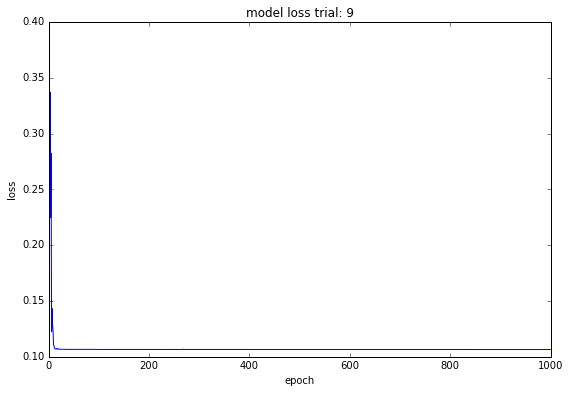

_-_-_-_-_-_-_-_-_-_-_-_-_-_
[0.0013777544954791665, 1.0, 1.0, 1.0, 1.0] ['loss', 'acc', 'precision', 'recall', 'fmeasure']


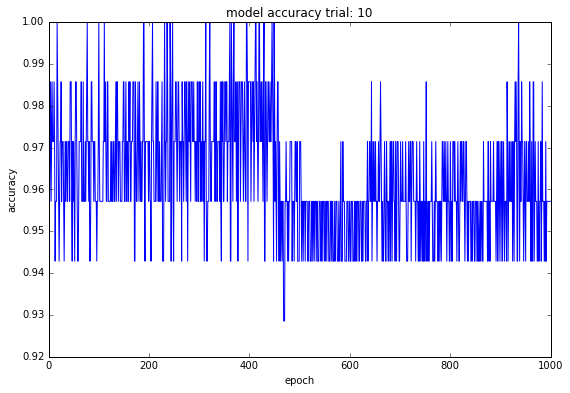

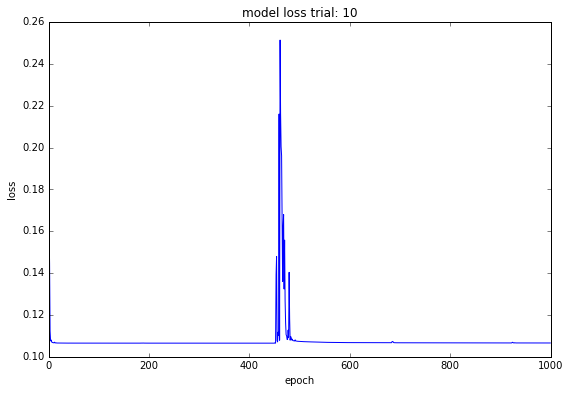

_-_-_-_-TEST-_-_-_-_-_
[0.13908803462982178, 0.89999997615814209, 1.0, 0.90909093618392944, 0.95238089561462402] ['loss', 'acc', 'precision', 'recall', 'fmeasure']
[ 1  3  3  3  2  0 11  3  6  5]
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]]


In [12]:
lasttest = None
for train, vaild in folds:
    lasttest = train_group((X[train],Y[train]),(X[vaild],Y[vaild]),trial)
    # lasttest = test_fold(train, test,trial, lasttest=lasttest)
    trial += 1
test_group((x_test,y_test))

In [13]:
for i, scs in enumerate(zip(accs, precs, recs, fscores)):
    print('Stat report for round %s: Acc. %.2f%% | Prec. %.2f%% | Rec. %.2f%% | Fscore %.2f%%' % (i + 1, scs[0], scs[1], scs[2], scs[3]))
print('Average accuracy over all rounds: %.2f%% (+/- %.2f%%)' % (np.mean(accs), np.std(accs)))
print('Average precision over all rounds: %.2f%% (+/- %.2f%%)' % (np.mean(precs), np.std(precs)))
print('Average recall over all rounds: %.2f%% (+/- %.2f%%)' % (np.mean(recs), np.std(recs)))
print('Average Fscore over all rounds: %.2f%% (+/- %.2f%%)' % (np.mean(fscores), np.std(fscores)))

Stat report for round 1: Acc. 25.00% | Prec. 28.57% | Rec. 25.00% | Fscore 26.67%
Stat report for round 2: Acc. 100.00% | Prec. 100.00% | Rec. 87.50% | Fscore 93.33%
Stat report for round 3: Acc. 62.50% | Prec. 75.00% | Rec. 60.00% | Fscore 66.67%
Stat report for round 4: Acc. 87.50% | Prec. 87.50% | Rec. 87.50% | Fscore 87.50%
Stat report for round 5: Acc. 100.00% | Prec. 100.00% | Rec. 100.00% | Fscore 100.00%
Stat report for round 6: Acc. 87.50% | Prec. 87.50% | Rec. 87.50% | Fscore 87.50%
Stat report for round 7: Acc. 75.00% | Prec. 87.50% | Rec. 70.00% | Fscore 77.78%
Stat report for round 8: Acc. 42.86% | Prec. 57.14% | Rec. 50.00% | Fscore 53.33%
Stat report for round 9: Acc. 85.71% | Prec. 85.71% | Rec. 85.71% | Fscore 85.71%
Stat report for round 10: Acc. 100.00% | Prec. 100.00% | Rec. 100.00% | Fscore 100.00%
Stat report for round 11: Acc. 90.00% | Prec. 100.00% | Rec. 90.91% | Fscore 95.24%
Average accuracy over all rounds: 77.82% (+/- 23.60%)
Average precision over all roun